In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
tf.compat.v1.enable_eager_execution()

In [6]:
inputs_train = np.load("inputs_train.npy")
inputs_test = np.load("inputs_test.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'inputs_train.npy'

In [ ]:
inputs_train = np.transpose(inputs_train, (0, 2,3,1))
inputs_test = np.transpose(inputs_test, (0, 2,3,1))

In [ ]:
inputs_train = inputs_train.reshape(inputs_train.shape[:2] + (inputs_train.shape[2]*inputs_train.shape[3],))
inputs_test = inputs_test.reshape(inputs_test.shape[:2] + (inputs_test.shape[2]*inputs_test.shape[3],))

In [ ]:
train = pd.read_csv('train_timeframes.csv').iloc[59:]
test = pd.read_csv('test_timeframes.csv').iloc[59:]

In [ ]:
df = [train, test]

In [ ]:
img = inputs_train[0,:,:]

In [ ]:
inputs_train.shape, train.shape

In [ ]:
inputs_test.shape, test.shape

In [14]:
idx = 0
batch_size = 32
stop_limit = 0.004
price_limit = 0.004
margin_size = 50
time_limit = 60

In [15]:
model = models.Sequential()
# model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
model.add(LSTM(32, input_shape = img.shape, dropout=0.5))
# model.add(LSTM(32, dropout=0.2))
model.add(Dense(3, activation = "sigmoid"))

In [15]:
# model = models.Sequential()

# model.add(Conv2D(32, (5, 1),padding ='Same', activation='relu', input_shape = img.shape))
# model.add(Conv2D(32, (5, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D((2, 1)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3, 1),padding = 'Same', activation ='relu'))
# model.add(Conv2D(64, (3, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation = "sigmoid"))

In [15]:
# model = tf.keras.models.load_model('profit_model/', compile=False)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6784      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 6,883
Trainable params: 6,883
Non-trainable params: 0
_________________________________________________________________


In [70]:
all_closes_train = tf.convert_to_tensor([[df[0].iloc[i+j:i+j+time_limit]['close_1min'].tolist() for j in range(batch_size)] for i in range(len(df[0])-buffer)]) 

In [71]:
all_closes_test = tf.convert_to_tensor([[df[1].iloc[i+j:i+j+time_limit]['close_1min'].tolist() for j in range(batch_size)] for i in range(len(df[1])-buffer)])

In [62]:
all_spread_train = tf.convert_to_tensor([df[0].iloc[i:i+1]['spread'].tolist() for i in range(len(df[0])-buffer)])
all_spread_test = tf.convert_to_tensor([df[1].iloc[i:i+1]['spread'].tolist() for i in range(len(df[1])-buffer)])

In [119]:
all_closes_train = np.save('all_closes_train', all_closes_train.numpy())
all_closes_test = np.save('all_closes_test', all_closes_test.numpy())
all_spread_train = np.save('all_spread_train', all_spread_train.numpy())
all_spread_test = np.save('all_spread_test', all_spread_test.numpy())

In [17]:
all_closes_train = tf.convert_to_tensor(np.load('all_closes_train.npy'))
all_closes_test = tf.convert_to_tensor(np.load('all_closes_test.npy'))
all_spread_train = tf.convert_to_tensor(np.load('all_spread_train.npy'))
all_spread_test = tf.convert_to_tensor(np.load('all_spread_test.npy'))

In [18]:
all_closes_train.shape

TensorShape([72603, 32, 60])

In [19]:
def custom_loss_wrapper(idx, stop_limit, price_limit, margin_size):  
    def custom_loss(y_true, y_pred):
        margin = ((y_pred[:,:1] - 0.5) * 2)
        margin *= margin_size
        direction = tf.sign(margin)
        stop_loss = y_pred[:,1:2] * direction * -1 * stop_limit
        price_target = y_pred[:,2:3] * direction * 1 * price_limit
        
        idx = y_true[0][1]
        df_name = y_true[0][0]
        batch_size = y_pred.shape[0]
        closes = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_closes_train, idx), lambda: tf.gather(all_closes_test, idx))
        closes = closes[:,:batch_size]
        spread = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_spread_train, idx), lambda: tf.gather(all_spread_test, idx))
        close1 = closes[:,:1]
        close2 = tf.zeros_like(closes[:,:1])
        lower_bound = tf.minimum(stop_loss, price_target)
        upper_bound = tf.maximum(stop_loss, price_target)
        i = tf.constant(0)
        def while_condition(i, close2): 
            return tf.less(i, tf.constant(closes.shape[1]))
        def body(i, close2):
            s = tf.slice(closes, [0, i], [closes.shape[0], 1])
            diff = (s  - close1) * direction
            cond = tf.logical_or(tf.less(diff, lower_bound), tf.greater(diff, upper_bound))
            close2 = tf.where(tf.logical_and(tf.equal(close2, 0), cond), s, close2)
            return [tf.add(i, 1), close2]
        r = tf.while_loop(while_condition, body, [i, close2], parallel_iterations=closes.shape[1], swap_memory=True)#, shape_invariants=[0, close2])
            
        close2 = tf.where(tf.equal(close2, 0), closes[:,-1:], close2)

        diff = close2 - close1
        profit = 100 * (margin * (diff - (spread*direction))) /  close1
        sharpe = (252 ** 0.5) * tf.reduce_mean(profit) / tf.math.reduce_std(profit)
        return -sharpe
    return custom_loss

In [20]:
def get_profit(data, y_preds, margin_lower_limit=0):
    idx = 0
    profits = []
    while idx < len(y_preds) - 1:
        margin = ((y_preds[idx][0] - 0.5) * 2)
        margin *= margin_size
        if abs(margin) < margin_lower_limit:
            idx += 1
        else:
            direction = np.sign(margin)
            stop_loss = y_preds[idx][1] * direction * -1 * stop_limit
            price_target = y_preds[idx][2] * direction * 1 * price_limit

            start_idx = idx
            close1 =  data.iloc[idx]['close_1min']
            spread = data.iloc[idx]['spread']
            idx += 1
            new_i = idx
            while new_i < len(data) - 1 and new_i - start_idx < time_limit:
                close2 = data.iloc[new_i]['close_1min']
                diff = (close2 - close1) 
                if min(stop_loss, price_limit) < diff * direction < max(stop_loss, price_limit):
                    break
                new_i += 1
            profit = 100 * (margin * (diff - (spread*direction))) /  close1
#             print(profit)
            profits.append(profit)
#             break
    return profits

# data = df[]

In [24]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
#             score = np.mean(custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)(tf.convert_to_tensor(self.y_val), tf.convert_to_tensor(y_pred)))
#             profits = get_profit(df[1], y_pred)
#             profits_0 = get_profit(df[1], y_pred, 0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))
#             print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])), interval=3)

In [22]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=custom_loss_wrapper(idx, stop_limit, price_limit, margin_size),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=False
)

In [26]:
history = model.fit(tf.convert_to_tensor(inputs_train[:-buffer-(len(inputs_train)-buffer)%batch_size]), 
                    tf.convert_to_tensor([[0, i] for i in range(len(train)-buffer-(len(inputs_train)-buffer)%batch_size)]), 
                    validation_data=(tf.convert_to_tensor(inputs_test[:-buffer-(len(inputs_test)-buffer)%batch_size]), tf.convert_to_tensor([[1, i] for i in range(len(test)-buffer-(len(inputs_test)-buffer)%batch_size)])),
                    epochs=10000, shuffle=True,
                    batch_size=batch_size,
                    callbacks=[ival],
                   use_multiprocessing=True, verbose=1, 
                    validation_freq=1,
                    workers=32,
                   initial_epoch=model.history.epoch[-1],
                   )

Epoch 1000/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8742 - val_loss: 4.1423
[0.48914224 0.31304204 0.19939837]
[0.5189687  0.5019916  0.49515387]
[1.         0.7742817  0.65772843]
Epoch 1001/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8501 - val_loss: 4.3225
Epoch 1002/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5471 - val_loss: 4.4495
Epoch 1003/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9910 - val_loss: 6.2454
[0.4554989  0.31073052 0.13269937]
[0.5167454 0.5010154 0.4895994]
[1.         0.6897696  0.61536425]
Epoch 1004/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6758 - val_loss: 4.3489
Epoch 1005/10000
2268/2268 [==============================] - 22s 9ms/step - loss: 0.7593 - val_loss: 4.4479
Epoch 1006/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7522 - val_loss: 4.3373
[0.48922542 0.3858668  0

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6473 - val_loss: 3.9589
Epoch 1113/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7391 - val_loss: 4.2741
Epoch 1114/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6334 - val_loss: 3.9330
[0.50054353 0.39098865 0.27358013]
[0.50939816 0.500268   0.4991367 ]
[1.         0.70669097 0.5618808 ]
Epoch 1115/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9261 - val_loss: 4.0092
Epoch 1116/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6670 - val_loss: 4.2428
Epoch 1117/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8922 - val_loss: 6.0003
[0.49540517 0.39400452 0.27076712]
[0.5051345  0.50025564 0.49918756]
[1.         0.73268735 0.5740895 ]
Epoch 1118/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6975 - val_loss: 4.7574
Epoch 1119/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7088 - val_loss: 6.2586
Epoch 1170/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 1.0251 - val_loss: 6.2252
Epoch 1171/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8047 - val_loss: 5.6648
[0.49930188 0.21066996 0.3037759 ]
[0.5192892  0.49385253 0.5003816 ]
[1.         0.68169403 0.66518605]
Epoch 1172/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 1.0142 - val_loss: 6.1964
Epoch 1173/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7590 - val_loss: 5.9746
Epoch 1174/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9307 - val_loss: 4.2398
[0.50015444 0.1679278  0.3437388 ]
[0.52816117 0.4901099  0.50321996]
[1.         0.5544572  0.76746106]
Epoch 1175/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7629 - val_loss: 4.3224
Epoch 1176/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7460 - val_loss: 6.0467
Epoch 1227/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9153 - val_loss: 4.6676
Epoch 1228/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8581 - val_loss: 5.4030
[0.15678966 0.20113462 0.34703374]
[0.50896996 0.49771026 0.50040436]
[1.        0.5136266 0.6620049]
Epoch 1229/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8313 - val_loss: 6.1206
Epoch 1230/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 1.1162 - val_loss: 4.0004
Epoch 1231/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6579 - val_loss: 6.0395
[0.34884918 0.20166093 0.34419167]
[0.50951326 0.4972661  0.5001072 ]
[1.         0.5526391  0.65051734]
Epoch 1232/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7307 - val_loss: 4.3526
Epoch 1233/10000
2268/2268 [============

2268/2268 [==============================] - 21s 9ms/step - loss: 0.7382 - val_loss: 4.1747
Epoch 1284/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5839 - val_loss: 4.6837
Epoch 1285/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8036 - val_loss: 5.9502
[0.42138585 0.3244737  0.2378287 ]
[0.50176805 0.49916166 0.49906778]
[1.         0.5812383  0.52448535]
Epoch 1286/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8519 - val_loss: 4.5295
Epoch 1287/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7730 - val_loss: 3.8787
Epoch 1288/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 1.0355 - val_loss: 6.0460
[0.48544028 0.3366278  0.2395375 ]
[0.50441253 0.49941623 0.4992875 ]
[1.        0.5630302 0.5383576]
Epoch 1289/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6079 - val_loss: 5.8249
Epoch 1290/10000
2268/2268 [=============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7806 - val_loss: 4.3657
Epoch 1341/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7097 - val_loss: 4.3485
Epoch 1342/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8561 - val_loss: 4.1072
[0.29522702 0.34545738 0.29922116]
[0.5088068  0.49915683 0.49967346]
[1.         0.54280674 0.51945466]
Epoch 1343/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.4823 - val_loss: 4.3128
Epoch 1344/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8008 - val_loss: 4.1526
Epoch 1345/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9465 - val_loss: 4.4451
[0.36250114 0.319713   0.26282012]
[0.511064   0.499131   0.49986392]
[1.         0.55598265 0.53973633]
Epoch 1346/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8556 - val_loss: 6.1828
Epoch 1347/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7207 - val_loss: 4.4445
Epoch 1398/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7082 - val_loss: 4.5188
Epoch 1399/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.6242 - val_loss: 4.3736
[0.49892172 0.33666772 0.36306792]
[0.51203644 0.49922308 0.49959058]
[1.        0.5738313 0.6014952]
Epoch 1400/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.8525 - val_loss: 3.3258
Epoch 1401/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7834 - val_loss: 4.2662
Epoch 1402/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6799 - val_loss: 4.1758
[0.50118685 0.33560604 0.36110312]
[0.5099338  0.4992551  0.49961925]
[1.         0.5675355  0.59265906]
Epoch 1403/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7206 - val_loss: 4.0883
Epoch 1404/10000
2268/2268 [==============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6052 - val_loss: 4.4811
Epoch 1455/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7327 - val_loss: 5.7157
Epoch 1456/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6666 - val_loss: 4.2377
[0.48781875 0.2604558  0.3585831 ]
[0.5114921  0.49881834 0.49949244]
[1.         0.57950914 0.5963739 ]
Epoch 1457/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7684 - val_loss: 6.1761
Epoch 1458/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9074 - val_loss: 4.1010
Epoch 1459/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7484 - val_loss: 4.2623
[0.01189995 0.23865706 0.3428245 ]
[0.50987715 0.4985639  0.49958298]
[1.         0.57283306 0.7270123 ]
Epoch 1460/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6260 - val_loss: 4.5344
Epoch 1461/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7385 - val_loss: 3.9488
Epoch 1512/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7251 - val_loss: 4.1917
Epoch 1513/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7413 - val_loss: 4.0714
[0.5009424  0.33436936 0.31153747]
[0.51104736 0.49970308 0.4991641 ]
[1.        0.6046431 0.5978499]
Epoch 1514/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8995 - val_loss: 4.0934
Epoch 1515/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7707 - val_loss: 5.9720
Epoch 1516/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.6594 - val_loss: 6.1064
[0.49709406 0.34966403 0.32129186]
[0.5071177  0.499894   0.49910355]
[1.        0.6014529 0.5921457]
Epoch 1517/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6893 - val_loss: 4.3382
Epoch 1518/10000
2268/2268 [================

2268/2268 [==============================] - 22s 10ms/step - loss: 0.8135 - val_loss: 4.2804
Epoch 1569/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7011 - val_loss: 4.3828
Epoch 1570/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9299 - val_loss: 6.1975
[0.49794763 0.36507612 0.32383853]
[0.5110113  0.49965975 0.49833712]
[1.         0.61514074 0.5523115 ]
Epoch 1571/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8273 - val_loss: 2.8248
Epoch 1572/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6474 - val_loss: 6.2648
Epoch 1573/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8468 - val_loss: 5.7745
[0.49952367 0.36127672 0.3062516 ]
[0.5144604  0.49879178 0.49692282]
[1.         0.6222515  0.54778135]
Epoch 1574/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8440 - val_loss: 6.2233
Epoch 1575/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.9291 - val_loss: 4.1862
Epoch 1626/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8300 - val_loss: 3.9807
Epoch 1627/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8186 - val_loss: 4.2272
[0.46712366 0.37801665 0.37312388]
[0.5134795  0.5001563  0.49866858]
[1.         0.60734737 0.54651856]
Epoch 1628/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8010 - val_loss: 6.1352
Epoch 1629/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8137 - val_loss: 4.3422
Epoch 1630/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7374 - val_loss: 3.6003
[0.50007504 0.33656424 0.3714041 ]
[0.5121297  0.50004643 0.49848622]
[1.         0.61013806 0.556219  ]
Epoch 1631/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8041 - val_loss: 3.5151
Epoch 1632/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7984 - val_loss: 4.2750
Epoch 1683/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5420 - val_loss: 4.3219
Epoch 1684/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6682 - val_loss: 4.1594
[0.5016792  0.46001753 0.37226635]
[0.5103254  0.5002964  0.49934125]
[1.         0.62705255 0.5250542 ]
Epoch 1685/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7489 - val_loss: 6.0905
Epoch 1686/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7769 - val_loss: 3.7494
Epoch 1687/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8066 - val_loss: 3.8513
[0.5005346  0.44768694 0.3743676 ]
[0.50962603 0.5003441  0.49923837]
[1.         0.61756325 0.5079258 ]
Epoch 1688/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6901 - val_loss: 4.0907
Epoch 1689/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.8500 - val_loss: 4.5701
Epoch 1740/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9948 - val_loss: 4.2155
Epoch 1741/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6154 - val_loss: 4.5774
[0.507186   0.43962815 0.32321805]
[0.515583   0.5007152  0.49933589]
[1.         0.693261   0.58940846]
Epoch 1742/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7476 - val_loss: 4.0275
Epoch 1743/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7501 - val_loss: 3.5583
Epoch 1744/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.5602 - val_loss: 3.5302
[0.49997532 0.44531265 0.29714203]
[0.50863993 0.5007924  0.49928242]
[1.         0.69542414 0.59590757]
Epoch 1745/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7997 - val_loss: 4.3016
Epoch 1746/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7680 - val_loss: 4.1984
Epoch 1797/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.7596 - val_loss: 6.0118
Epoch 1798/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9328 - val_loss: 3.6970
[0.4493589  0.4499217  0.40384576]
[0.50689894 0.50031215 0.49962726]
[1.         0.65202355 0.52115864]
Epoch 1799/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7821 - val_loss: 5.8194
Epoch 1800/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8396 - val_loss: 6.1725
Epoch 1801/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8030 - val_loss: 3.9596
[0.33691904 0.44461346 0.4131303 ]
[0.5082848  0.5003141  0.49954614]
[1.         0.6311204  0.51074404]
Epoch 1802/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8243 - val_loss: 6.1795
Epoch 1803/10000
2268/2268 [==========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7728 - val_loss: 4.1044
Epoch 1854/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8012 - val_loss: 6.1884
Epoch 1855/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9621 - val_loss: 4.3222
[0.5024916 0.4524126 0.3974912]
[0.50987935 0.5000742  0.4997048 ]
[1.         0.59480524 0.5240637 ]
Epoch 1856/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8411 - val_loss: 4.3622
Epoch 1857/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9072 - val_loss: 4.3691
Epoch 1858/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9181 - val_loss: 4.1486
[0.49678993 0.44522536 0.3912632 ]
[0.5087443 0.5001061 0.4996443]
[1.         0.59915227 0.5299245 ]
Epoch 1859/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6415 - val_loss: 4.5449
Epoch 1860/10000
2268/2268 [===============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7971 - val_loss: 4.2509
Epoch 1911/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9079 - val_loss: 6.1623
Epoch 1912/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7442 - val_loss: 4.2153
[0.501369   0.4982105  0.43601725]
[0.50838965 0.5000958  0.49976593]
[1.        0.534461  0.5015792]
Epoch 1913/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7629 - val_loss: 4.3005
Epoch 1914/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.7351 - val_loss: 3.9677
Epoch 1915/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9777 - val_loss: 4.1887
[0.5002177  0.49900198 0.44424602]
[0.5078729  0.5000798  0.49979007]
[1.         0.53405607 0.50061136]
Epoch 1916/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 1.0148 - val_loss: 4.1932
Epoch 1917/10000
2268/2268 [=============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6680 - val_loss: 4.3487
Epoch 1968/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9022 - val_loss: 3.9104
Epoch 1969/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8274 - val_loss: 3.7723
[0.50051075 0.49113312 0.41158554]
[0.50918114 0.50012606 0.49950993]
[1.         0.5802766  0.50001335]
Epoch 1970/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8098 - val_loss: 6.0599
Epoch 1971/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7149 - val_loss: 6.1563
Epoch 1972/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8233 - val_loss: 4.2144
[0.5035167  0.49196556 0.41295144]
[0.51267636 0.5001601  0.4994804 ]
[1.        0.5764481 0.5000137]
Epoch 1973/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5695 - val_loss: 3.9295
Epoch 1974/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.8187 - val_loss: 4.4568
Epoch 2025/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9585 - val_loss: 3.8066
Epoch 2026/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8314 - val_loss: 6.0872
[0.49713066 0.48114222 0.4057007 ]
[0.50624263 0.5002504  0.49952948]
[1.         0.56681085 0.53292304]
Epoch 2027/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8167 - val_loss: 6.2150
Epoch 2028/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8223 - val_loss: 4.3238
Epoch 2029/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6786 - val_loss: 3.9835
[0.50124586 0.4840547  0.4027872 ]
[0.51081073 0.50033957 0.4994588 ]
[1.         0.57727796 0.5201859 ]
Epoch 2030/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9227 - val_loss: 3.9466
Epoch 2031/10000
2268/2268 [=========

2268/2268 [==============================] - 23s 10ms/step - loss: 0.9063 - val_loss: 3.9730
Epoch 2082/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8026 - val_loss: 6.1943
Epoch 2083/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6326 - val_loss: 4.2357
[0.5048357  0.45709676 0.41449225]
[0.5149315 0.49986   0.4995528]
[1.         0.5408201  0.53374803]
Epoch 2084/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7187 - val_loss: 3.7741
Epoch 2085/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8169 - val_loss: 4.0443
Epoch 2086/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7922 - val_loss: 6.1506
[0.49522147 0.4627185  0.4212603 ]
[0.5048391 0.4998337 0.4995764]
[1.         0.5402657  0.52887815]
Epoch 2087/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8244 - val_loss: 4.3786
Epoch 2088/10000
2268/2268 [===============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6639 - val_loss: 4.0031
Epoch 2139/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7040 - val_loss: 4.2472
Epoch 2140/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8851 - val_loss: 4.0232
[0.48564938 0.4699886  0.41971   ]
[0.51409423 0.49988407 0.4995094 ]
[1.         0.56099045 0.54211545]
Epoch 2141/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7817 - val_loss: 3.2148
Epoch 2142/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8717 - val_loss: 5.9840
Epoch 2143/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6462 - val_loss: 3.7589
[0.4935729  0.47117493 0.41928098]
[0.5138269  0.49990556 0.49947825]
[1.         0.5616408  0.53150374]
Epoch 2144/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7885 - val_loss: 4.1275
Epoch 2145/10000
2268/2268 [=========

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7656 - val_loss: 3.9736
Epoch 2196/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8301 - val_loss: 3.8453
Epoch 2197/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8097 - val_loss: 3.9209
[0.50066286 0.4806885  0.40676636]
[0.51245993 0.4999917  0.49960425]
[1.        0.5965671 0.5563357]
Epoch 2198/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8348 - val_loss: 5.8455
Epoch 2199/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6788 - val_loss: 4.0977
Epoch 2200/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8716 - val_loss: 3.6099
[0.5000652  0.46413907 0.4049407 ]
[0.51153105 0.49995494 0.4995766 ]
[1.         0.5690037  0.56420696]
Epoch 2201/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8860 - val_loss: 6.0751
Epoch 2202/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.8939 - val_loss: 3.7596
Epoch 2253/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6847 - val_loss: 5.8773
Epoch 2254/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7756 - val_loss: 3.7568
[0.5014832  0.4699342  0.37685293]
[0.51443034 0.50009465 0.499509  ]
[1.        0.5979492 0.5587037]
Epoch 2255/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7593 - val_loss: 5.8446
Epoch 2256/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7214 - val_loss: 5.9724
Epoch 2257/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7067 - val_loss: 4.2021
[0.5057659  0.469012   0.38280967]
[0.5183513  0.50015914 0.49946874]
[1.        0.5875665 0.5634054]
Epoch 2258/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7643 - val_loss: 3.6946
Epoch 2259/10000
2268/2268 [===============

2268/2268 [==============================] - 23s 10ms/step - loss: 0.7757 - val_loss: 2.8799
Epoch 2310/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8086 - val_loss: 3.7645
Epoch 2311/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7646 - val_loss: 2.7795
[0.4975865  0.45087638 0.42626226]
[0.51234573 0.49977362 0.49974948]
[1.        0.5792531 0.5516964]
Epoch 2312/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7070 - val_loss: 5.5837
Epoch 2313/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9097 - val_loss: 3.8602
Epoch 2314/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6985 - val_loss: 3.7483
[0.5001705  0.45251402 0.43112886]
[0.51534986 0.49987948 0.4997672 ]
[1.         0.58546036 0.55539787]
Epoch 2315/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7017 - val_loss: 3.1786
Epoch 2316/10000
2268/2268 [============

2268/2268 [==============================] - 23s 10ms/step - loss: 0.6457 - val_loss: 3.0427
Epoch 2367/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6065 - val_loss: 2.7044
Epoch 2368/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.4734 - val_loss: 3.3706
[0.50230795 0.4609983  0.4312461 ]
[0.516901  0.500145  0.4996981]
[1.        0.5903868 0.5408169]
Epoch 2369/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7505 - val_loss: 5.1992
Epoch 2370/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8485 - val_loss: 3.8917
Epoch 2371/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8336 - val_loss: 4.9169
[0.49506575 0.44010553 0.4309693 ]
[0.5139305 0.500182  0.4996653]
[1.        0.5935784 0.5303125]
Epoch 2372/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7636 - val_loss: 3.7404
Epoch 2373/10000
2268/2268 [=====================

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7679 - val_loss: 3.3254
Epoch 2424/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7097 - val_loss: 3.3682
Epoch 2425/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7401 - val_loss: 3.4222
[0.4928316 0.4137794 0.4425847]
[0.51703286 0.49948895 0.50001293]
[1.         0.62335247 0.54115254]
Epoch 2426/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7923 - val_loss: 3.4806
Epoch 2427/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8420 - val_loss: 3.2521
Epoch 2428/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7929 - val_loss: 3.7344
[0.4978562 0.4041189 0.4296577]
[0.51848686 0.4995491  0.50002086]
[1.        0.6254957 0.5403767]
Epoch 2429/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7672 - val_loss: 2.6547
Epoch 2430/10000
2268/2268 [==================

2268/2268 [==============================] - 22s 10ms/step - loss: 0.8649 - val_loss: 3.1600
Epoch 2481/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6392 - val_loss: 3.6996
Epoch 2482/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5940 - val_loss: 5.5416
[0.465039   0.3819437  0.40048516]
[0.5128693  0.49922654 0.49985316]
[1.         0.6379895  0.55748016]
Epoch 2483/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7630 - val_loss: 5.0900
Epoch 2484/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6686 - val_loss: 5.6227
Epoch 2485/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6809 - val_loss: 3.9123
[0.4687606  0.38447633 0.41768405]
[0.51902246 0.4992266  0.49986678]
[1.        0.6437653 0.5602739]
Epoch 2486/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7376 - val_loss: 3.3435
Epoch 2487/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6736 - val_loss: 2.0185
Epoch 2538/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7644 - val_loss: 4.4340
Epoch 2539/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6806 - val_loss: 4.5611
[0.48193595 0.40113002 0.38526338]
[0.5112571  0.4985633  0.50008774]
[1.         0.6829223  0.54374284]
Epoch 2540/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9609 - val_loss: 4.8447
Epoch 2541/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7588 - val_loss: 2.4709
Epoch 2542/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7370 - val_loss: 4.9125
[0.48779824 0.37380803 0.4048227 ]
[0.51214594 0.49852002 0.500169  ]
[1.        0.6764013 0.5431487]
Epoch 2543/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6806 - val_loss: 4.9246
Epoch 2544/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7879 - val_loss: 5.4788
Epoch 2595/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5868 - val_loss: 3.6980
Epoch 2596/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9419 - val_loss: 2.5220
[0.4996182  0.39967456 0.39534938]
[0.5122247 0.5003628 0.5001893]
[1.        0.6647007 0.5434479]
Epoch 2597/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.5991 - val_loss: 3.1475
Epoch 2598/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7492 - val_loss: 3.7437
Epoch 2599/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7470 - val_loss: 3.7622
[0.4932225  0.39932698 0.40754032]
[0.5134083  0.5011236  0.50021166]
[1.        0.6329676 0.5451408]
Epoch 2600/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7893 - val_loss: 2.8028
Epoch 2601/10000
2268/2268 [==================

2268/2268 [==============================] - 23s 10ms/step - loss: 0.8881 - val_loss: 3.5952
Epoch 2652/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7235 - val_loss: 2.8215
Epoch 2653/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9280 - val_loss: 5.3961
[0.4979471  0.39895833 0.33132583]
[0.5124149 0.4992471 0.5000509]
[1.         0.61378473 0.5399933 ]
Epoch 2654/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8401 - val_loss: 3.7711
Epoch 2655/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8093 - val_loss: 3.3751
Epoch 2656/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8019 - val_loss: 3.8855
[0.46179503 0.39399457 0.3436327 ]
[0.51834697 0.4989684  0.50007087]
[1.         0.61376053 0.5413841 ]
Epoch 2657/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8854 - val_loss: 5.1521
Epoch 2658/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7102 - val_loss: 3.6565
Epoch 2709/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8920 - val_loss: 3.0284
Epoch 2710/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6612 - val_loss: 5.3001
[0.49811223 0.39086646 0.2926729 ]
[0.5146203  0.4986225  0.50008833]
[1.         0.6313116  0.55674934]
Epoch 2711/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.9891 - val_loss: 3.7853
Epoch 2712/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8003 - val_loss: 3.6072
Epoch 2713/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6066 - val_loss: 3.1875
[0.50184804 0.3935737  0.30959594]
[0.5181348  0.49919614 0.50000066]
[1.        0.6317239 0.5532528]
Epoch 2714/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6704 - val_loss: 5.2912
Epoch 2715/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7005 - val_loss: 3.1519
Epoch 2766/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8206 - val_loss: 5.6613
Epoch 2767/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7567 - val_loss: 3.2834
[0.50003093 0.39939913 0.25613093]
[0.51517487 0.5008526  0.4999028 ]
[1.         0.6753623  0.56714034]
Epoch 2768/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8312 - val_loss: 2.2070
Epoch 2769/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6091 - val_loss: 4.7265
Epoch 2770/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7004 - val_loss: 3.6266
[0.49984142 0.39740875 0.24364668]
[0.51653105 0.50004584 0.4993289 ]
[1.        0.6576827 0.5681231]
Epoch 2771/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6613 - val_loss: 3.2243
Epoch 2772/10000
2268/2268 [============

2268/2268 [==============================] - 22s 10ms/step - loss: 0.7216 - val_loss: 5.1705
Epoch 2823/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6766 - val_loss: 3.8310
Epoch 2824/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7484 - val_loss: 4.1042
[0.48555195 0.39337593 0.29957467]
[0.5214851 0.5007634 0.5002024]
[1.        0.6943399 0.6026798]
Epoch 2825/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.7056 - val_loss: 3.4539
Epoch 2826/10000
2268/2268 [==============================] - 21s 9ms/step - loss: 0.8536 - val_loss: 2.9629
Epoch 2827/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7991 - val_loss: 4.1263
[0.49929857 0.38905013 0.30337182]
[0.5168745  0.50046057 0.50004447]
[1.         0.70152676 0.60315424]
Epoch 2828/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7727 - val_loss: 5.7518
Epoch 2829/10000
2268/2268 [=================

2268/2268 [==============================] - 22s 10ms/step - loss: 0.6637 - val_loss: 3.4810
Epoch 2880/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.8498 - val_loss: 3.5884
Epoch 2881/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7503 - val_loss: 3.9199
[0.49855646 0.38828525 0.24459735]
[0.51764905 0.5011877  0.49969637]
[1.        0.6826565 0.5692798]
Epoch 2882/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.6972 - val_loss: 3.5967
Epoch 2883/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7088 - val_loss: 2.8987
Epoch 2884/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7120 - val_loss: 3.8807
[0.50398296 0.3891156  0.2574861 ]
[0.52012163 0.50200474 0.49984697]
[1.         0.6881125  0.56977654]
Epoch 2885/10000
2268/2268 [==============================] - 22s 10ms/step - loss: 0.7813 - val_loss: 5.4223
Epoch 2886/10000
2268/2268 [============

2268/2268 [==============================] - 23s 10ms/step - loss: 0.6705 - val_loss: 5.4511
Epoch 2937/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.7011 - val_loss: 3.0703
Epoch 2938/10000
2268/2268 [==============================] - 24s 11ms/step - loss: 0.8149 - val_loss: 2.8994
[0.4952022  0.33839712 0.19676432]
[0.5265604 0.4991599 0.4974084]
[1.         0.76940465 0.612622  ]
Epoch 2939/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8279 - val_loss: 2.7911
Epoch 2940/10000
2268/2268 [==============================] - 24s 10ms/step - loss: 0.5116 - val_loss: 3.5611
Epoch 2941/10000
2268/2268 [==============================] - 24s 11ms/step - loss: 0.9366 - val_loss: 5.2699
[0.43741408 0.34886873 0.19490778]
[0.52440524 0.49880642 0.49692592]
[1.         0.7444763  0.60539234]
Epoch 2942/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6564 - val_loss: 3.5916
Epoch 2943/10000
2268/2268 [============

2268/2268 [==============================] - 23s 10ms/step - loss: 0.8099 - val_loss: 1.5606
Epoch 2994/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.6791 - val_loss: 2.9514
Epoch 2995/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8115 - val_loss: 2.3222
[0.4352702  0.3062938  0.18900415]
[0.53540045 0.4836632  0.5003807 ]
[1.         0.75484765 0.61080587]
Epoch 2996/10000
2268/2268 [==============================] - 23s 10ms/step - loss: 0.8464 - val_loss: 3.4876
Epoch 2997/10000
2268/2268 [==============================] - 24s 10ms/step - loss: 0.6858 - val_loss: 2.6935
Epoch 2998/10000
2268/2268 [==============================] - 24s 10ms/step - loss: 0.8800 - val_loss: 2.9652
[0.41598082 0.2925509  0.19102338]
[0.53128237 0.48224828 0.5004065 ]
[1.        0.7528691 0.6112423]
Epoch 2999/10000
2268/2268 [==============================] - 24s 10ms/step - loss: 0.7208 - val_loss: 2.3920
Epoch 3000/10000
2268/2268 [============

KeyboardInterrupt: 

In [52]:
model.save('profit_model_fast')

INFO:tensorflow:Assets written to: profit_model\assets


INFO:tensorflow:Assets written to: profit_model\assets


In [21]:
y_preds = {'train': model.predict(inputs_train[:-buffer]), 'test': model.predict(inputs_test[:-buffer])}

In [24]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [25]:
temp = {'train': train.iloc[:-buffer-1].copy(), 'test': test.iloc[:-buffer-1].copy()}
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:>

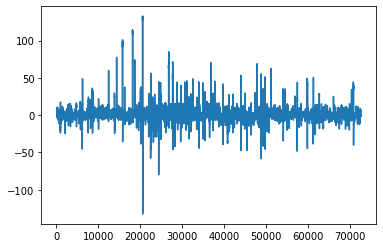

In [26]:
temp['train']['profit'].plot()

<AxesSubplot:>

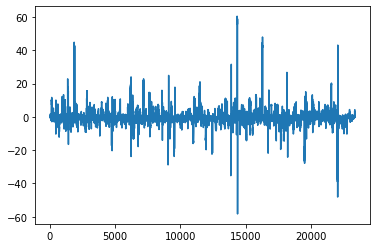

In [27]:
temp['test']['profit'].plot()

<AxesSubplot:>

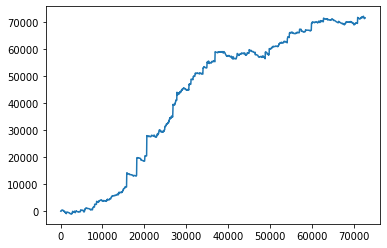

In [28]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

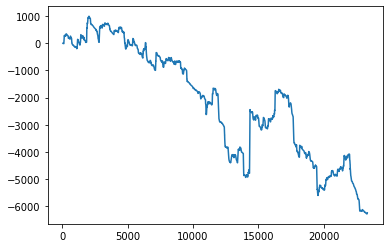

In [29]:
temp['test']['profit'].cumsum().plot()

In [30]:
sum(profits['train'])

71683.21018249515

In [31]:
sum(profits['test'])

-6236.254349987728

In [32]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

1.836031539659188

In [33]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

-0.8594396218016983